In [79]:
# Import Libraries 
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree, metrics
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap



In [6]:
# Read In csv
df = pd.read_csv('ks-projects-201801.csv')

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Doing some EDA

In [ ]:
# Printing information about variables in Dataset
df.info()

In [ ]:
# Checking for unique values for every column 
for col in df:
    print(df[col].unique())

In [10]:
# Base accuracy: failure rate is ~62%, success rate is 36%
df['state'].value_counts(normalize=True)

failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: state, dtype: float64

## Wrangle function to read and clean data

In [ ]:
# loading data and cleaning dataset
def wrangle(file_path):
    
    #reading in data, parsing the two date columns
    df = pd.read_csv(file_path, parse_dates=['deadline', 'launched'], na_values=['N,0"'])

    #dropping any live campaigns
    df = df.query('state != "live"')

    #creating new column 'success' will have a 1 if state is succesfull, else 0
    df.loc[df['state'] == 'successful', 'success'] = 1
    df.loc[df['state'] != 'successful', 'success'] = 0

    
    #creating new columns for the dates
    df = df.assign(hour=df.launched.dt.hour,
               day=df.launched.dt.day,
               month=df.launched.dt.month,
               year=df.launched.dt.year)
               
    return df

df = wrangle("ks-projects-201801.csv");

## Doing EDA on new Dataset

In [12]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0.0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0.0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0.0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0.0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0.0,8,4,7,2015


In [195]:
# Get top 10 most frequent names
n=10
df['name'].value_counts()[:n].index.tolist()


['New EP/Music Development',
 'Canceled (Canceled)',
 'Music Video',
 'N/A (Canceled)',
 'Cancelled (Canceled)',
 'New EP / Music Development',
 'Debut Album',
 'The Journey',
 'Reflections',
 "A Midsummer Night's Dream"]

In [14]:
# Summary statisticts about Dataset
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,success,hour,day,month,year
count,3.758620e+05,3.758620e+05,3.758620e+05,375862.000000,3.720660e+05,3.758620e+05,3.758620e+05,375862.000000,375862.000000,375862.000000,375862.000000,375862.000000
mean,1.074660e+09,4.887465e+04,9.687431e+03,105.896866,7.080215e+03,9.082678e+03,4.532720e+04,0.356397,13.091637,15.294741,6.425403,2014.227014
std,6.191365e+08,1.176595e+06,9.588649e+04,909.952393,7.893105e+04,9.127075e+04,1.145865e+06,0.478935,7.712252,8.809024,3.310220,1.925235
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000,1.000000,1.000000,1970.000000
25%,5.380103e+08,2.000000e+03,3.000000e+01,2.000000,1.800000e+01,3.100000e+01,2.000000e+03,0.000000,5.000000,8.000000,4.000000,2013.000000
50%,1.075277e+09,5.100000e+03,6.250000e+02,12.000000,4.000000e+02,6.274500e+02,5.480000e+03,0.000000,16.000000,15.000000,6.000000,2014.000000
75%,1.610139e+09,1.600000e+04,4.090000e+03,56.000000,3.056957e+03,4.064462e+03,1.550000e+04,1.000000,20.000000,23.000000,9.000000,2016.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000,23.000000,31.000000,12.000000,2018.000000


## Checking for outliers


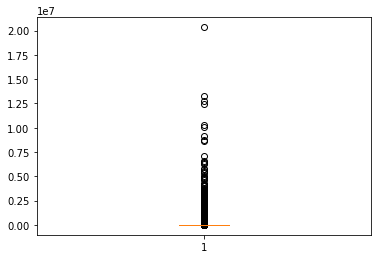

<Figure size 720x504 with 0 Axes>

In [197]:
plt.boxplot(df['pledged'])
fig = plt.figure(figsize =(10, 7))
plt.show()

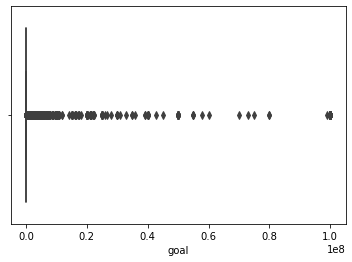

In [198]:
sns.boxplot(x=df['goal'])

In [15]:
Q1 = df['usd_pledged_real'].quantile(0.25)
Q3 = df['usd_pledged_real'].quantile(0.75)
IQR = Q3 - Q1

In [20]:
# Filtering values between Q1-1.5IQR and Q3+1.5IQR to exclude outliers
filtered = df.query('(@Q1 - 1.5 * @IQR) <= usd_pledged_real <= (@Q3 + 1.5 * @IQR)')

In [21]:
# Print a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean
print(filtered.skew())


ID                  -0.001749
goal                67.339900
pledged             65.931051
backers              5.061855
usd pledged          2.129705
usd_pledged_real     1.839102
usd_goal_real       74.778366
success              0.980646
hour                -0.396098
day                  0.059938
month                0.007826
year                -0.628928
dtype: float64


In [22]:
filtered.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0.0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0.0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0.0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0.0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0.0,8,4,7,2015


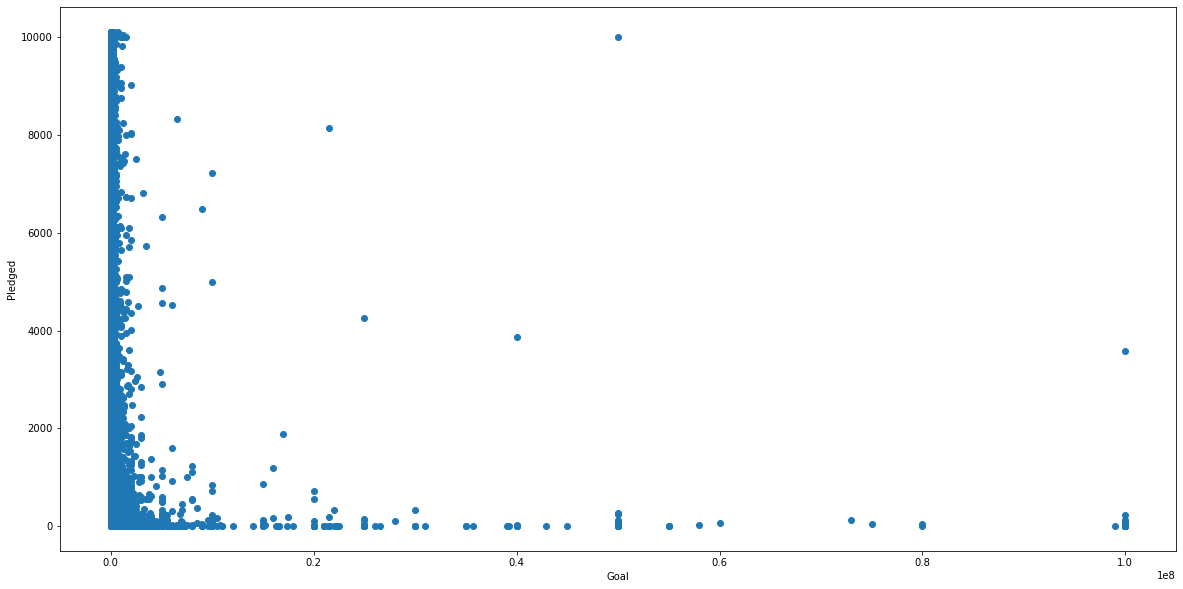

In [23]:
# Building scatterplot to see the correlation between two variables
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(filtered['goal'], filtered['usd_pledged_real'])
ax.set_xlabel('Goal')
ax.set_ylabel('Pledged')
plt.show()

In [24]:
#seeing how many unique values are there in the category column
filtered['category'].nunique()

159

In [27]:
# Base accuracy at this point: failure rate is ~72%, success rate is ~28%
filtered['success'].value_counts(normalize=True)

0.0    0.720124
1.0    0.279876
Name: success, dtype: float64

## Creating new columns with seasons and seasons_encoded values

In [ ]:
def seasons(date_ranges):
  season = ""
  if date_ranges is pd.NaT:
    return "NAN"
  else:
    #print(date_ranges)
    str_date_range = date_ranges.strftime("%m-%d")
    #print(date_ranges.strftime("%m-%d"))
    #print(date_ranges.strftime("%m-%d") > "08-26")
    if str_date_range >= "12-21" or str_date_range <= "03-20":
      season = "Winter"
    if str_date_range >= "03-21" and str_date_range <="06-20":
      season = "Spring"
    if str_date_range >="06-21" and str_date_range <="09-20":
      season = "Summer"
    if str_date_range >="09-21" and str_date_range <="12-20":
      season = "Fall"
    return season
    
filtered['launch_season'] = filtered['launched'].apply(seasons)
filtered['deadline_season'] = filtered['deadline'].apply(seasons)

In [ ]:
def season_encoder(values):
  inter = 0
  if values == "Spring":
    inter = 1
  elif values == "Summer":
    inter = 2
  elif values == "Fall":
    inter = 3
  elif values == "Winter":
    inter = 4
  else:
    inter = "NAN"
  return inter

filtered['launch_season_encode'] = filtered['launch_season'].apply(season_encoder)
filtered['deadline_season_encode'] = filtered['deadline_season'].apply(season_encoder)

## Creating new column with duration in days

In [ ]:
filtered['launched'] = pd.to_datetime(filtered['launched'])
filtered['deadline'] = pd.to_datetime(filtered['deadline'])
filtered['duration'] = filtered['deadline'] - filtered['launched']
filtered['duration'] = filtered['duration'].dt.days

In [31]:
filtered.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,success,hour,day,month,year,launch_season,deadline_season,launch_season_encode,deadline_season_encode,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,12,11,8,2015,Summer,Fall,2,3,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,0.0,4,2,9,2017,Summer,Fall,2,3,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,0.0,0,12,1,2013,Winter,Winter,4,4,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,0.0,3,17,3,2012,Winter,Spring,4,1,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,0.0,8,4,7,2015,Summer,Summer,2,2,55


## After doing some feature selection below, creating new DataFrame 

In [33]:
#choosing categorical features to be in the model
cat_features = ['country', 'currency', 'main_category']

#label encoding and creating new dataframe with encoded columns
encoder = LabelEncoder()
encoded = filtered[cat_features].apply(encoder.fit_transform)
encoded.head()

,country,currency,main_category
0,9,5,12
1,21,13,6
2,21,13,6
3,21,13,10
4,21,13,6


In [34]:
#choosing data columns to be in model and joining with categorical col above
data_features = ['goal', 'month', 'year', 'success', 'duration']
baseline = filtered[data_features].join(encoded)
baseline.head()

,goal,month,year,success,duration,country,currency,main_category
0,1000.0,8,2015,0.0,58,9,5,12
1,30000.0,9,2017,0.0,59,21,13,6
2,45000.0,1,2013,0.0,44,21,13,6
3,5000.0,3,2012,0.0,29,21,13,10
4,19500.0,7,2015,0.0,55,21,13,6


In [35]:
baseline_index = filtered['name']
baseline = baseline.join(baseline_index).set_index('name')
baseline.head()

,goal,month,year,success,duration,country,currency,main_category
name,,,,,,,,
The Songs of Adelaide & Abullah,1000.0,8,2015,0.0,58,9,5,12
Greeting From Earth: ZGAC Arts Capsule For ET,30000.0,9,2017,0.0,59,21,13,6
Where is Hank?,45000.0,1,2013,0.0,44,21,13,6
ToshiCapital Rekordz Needs Help to Complete Album,5000.0,3,2012,0.0,29,21,13,10
Community Film Project: The Art of Neighborhood Filmmaking,19500.0,7,2015,0.0,55,21,13,6


In [115]:
# Creates a csv
baseline.to_csv(r'ks-projects-201801.csv')

In [37]:
# Printing the pairwise correlation of all columns in the DataFrame
baseline.corr()

,goal,month,year,success,duration,country,currency,main_category
goal,1.000000,0.000797,0.016796,-0.023244,0.004253,-0.004800,-0.005344,0.004119
month,0.000797,1.000000,-0.092671,-0.017650,-0.010660,-0.026045,-0.026769,0.000834
year,0.016796,-0.092671,1.000000,-0.121966,-0.134405,-0.271355,-0.281491,-0.016819
success,-0.023244,-0.017650,-0.121966,1.000000,-0.027508,0.049682,0.058443,-0.034544
duration,0.004253,-0.010660,-0.134405,-0.027508,1.000000,0.005394,0.005461,0.007314
country,-0.004800,-0.026045,-0.271355,0.049682,0.005394,1.000000,0.975550,-0.008765
currency,-0.005344,-0.026769,-0.281491,0.058443,0.005461,0.975550,1.000000,-0.013972
main_category,0.004119,0.000834,-0.016819,-0.034544,0.007314,-0.008765,-0.013972,1.000000


In [39]:
# Creating target and feature variables
target = 'success'
X = baseline.drop(columns=target)
y = baseline[target]

In [40]:
# Splitting data into training and test data
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = .2, random_state = 42)

## Establishing Baseline

In [44]:
# The Baseline accuracy is the majority class in y_val and what percentage of the training observations it represents
baseline_acc = y_train.value_counts(normalize=True)[0]
print('Baseline Accuracy Score:', baseline_acc)


Baseline Accuracy Score: 0.719859584508258


## Building Models

### We are building not one but few different models to see which one is the best to make predictions

In [ ]:
# Creating and fitting model1 = XGBoost
model = XGBClassifier(label_encoder = False, random_state=42, n_estimators=50, n_jobs=-1, max_depth=15)
model.fit(X_train, y_train)


In [56]:
# Calculate the training and validation accuracy scores for model
training_accuracy = model.score(X_train, y_train)
val_accuracy = model.score(X_val, y_val)

print('Training Accuracy Score:', training_accuracy)
print('Validation Accuracy Score:', val_accuracy)

Training Accuracy Score: 0.851527881682684
Validation Accuracy Score: 0.7646246393714321


In [ ]:
# Creating and fitting model2 = LogisticRegression

model2 = LogisticRegression(random_state=42, solver='newton-cg')
model2.fit(X_train, y_train)

In [58]:
# Calculate the training and validation accuracy scores for model2
training_accuracy2 = model2.score(X_train, y_train)
val_accuracy2 = model2.score(X_val, y_val)
print('Training Accuracy Score:', training_accuracy2)
print('Validation Accuracy Score:', val_accuracy2)

Training Accuracy Score: 0.7352515777560377
Validation Accuracy Score: 0.7372168682094408


In [50]:
# Creating and fitting model3 = DecisionTree

model3 = tree.DecisionTreeClassifier(random_state=42)
model3.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [59]:
# Calculate the training and validation accuracy scores for model3
training_accuracy3 = model3.score(X_train, y_train)
val_accuracy3 = model3.score(X_val, y_val)
print('Training Accuracy Score:', training_accuracy3)
print('Validation Accuracy Score:', val_accuracy3)

Training Accuracy Score: 0.9408566879591798
Validation Accuracy Score: 0.7254005278988398


In [52]:
# Creating and fitting model4 = RandomForestClassifer

model4 = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
model4.fit(X_train, y_train);

In [60]:
# Calculate the training and validation accuracy scores for model4
training_accuracy4 = model4.score(X_train, y_train)
val_accuracy4 = model4.score(X_val, y_val)
print('Training Accuracy Score:', training_accuracy4)
print('Validation Accuracy Score:', val_accuracy4)

Training Accuracy Score: 0.9406763729834455
Validation Accuracy Score: 0.7444447854643669


In [54]:
# Creating and fitting model5 = GradientBoostingClassifer
model5 = GradientBoostingClassifier(random_state=42, n_estimators=150, min_samples_leaf=5, max_leaf_nodes=350, max_depth=4, learning_rate=0.25)
model5.fit(X_train, y_train);

In [61]:
# Calculate the training and validation accuracy scores for model5
training_accuracy5 = model5.score(X_train, y_train)
val_accuracy5 = model5.score(X_val, y_val)
print('Training Accuracy Score:', training_accuracy5)
print('Validation Accuracy Score:', val_accuracy5)

Training Accuracy Score: 0.777253457635572
Validation Accuracy Score: 0.7742158246884783


## Models Tuning

### To get better results we did hyperparameter tuning for each model and based on that we picked the model with the best score 

In [ ]:
#RandomizedSearchCV
#instead of choosing the hyperparameters manually, this helps you choose it  
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [150],
    'min_samples_leaf': [3, 4, 5],
    'max_leaf_nodes': [350, 370, 400],
    'learning_rate': [0.25, 0.3,]
    
}
search = RandomizedSearchCV(model5, 
                        param_distributions=param_grid, 
                        n_iter=5,
                        n_jobs=-1, 
                        cv=3, 
                        verbose=1)

search.fit(X_train, y_train);


In [ ]:
search.best_score_

In [ ]:
search.best_params_

### Making some predictions

In [64]:
y_pred = model5.predict(X_val)
y_pred

array([0., 1., 0., ..., 1., 0., 0.])

## Communicate Results

## Making plot to show feature importances

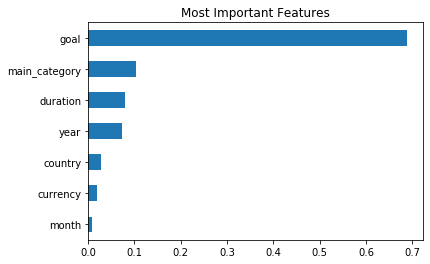

In [65]:
coef = pd.DataFrame(data=model5.feature_importances_, index=X_train.columns, columns=['coefficients'])
# Interested in the most extreme coefficients
coef['coefficients'].abs().sort_values().plot(kind='barh');
plt.title('Most Important Features')
plt.show()

## Classification Report

In [76]:
print(classification_report(y_val, model5.predict(X_val), target_names=['Not successful', 'Successful']))

                precision    recall  f1-score   support

Not successful       0.82      0.88      0.85     46995
    Successful       0.62      0.49      0.55     18169

      accuracy                           0.77     65164
     macro avg       0.72      0.69      0.70     65164
  weighted avg       0.76      0.77      0.77     65164



## Confusion Matrix to see how many predictions were made correct

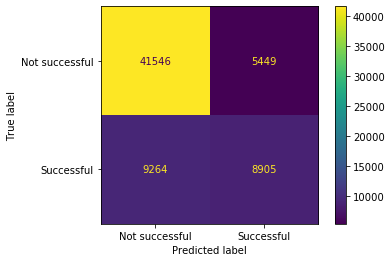

In [73]:
plot_confusion_matrix(
    model5,
    X_val,
    y_val,
    values_format = '.0f',
    display_labels = ['Not successful','Successful']
);

## Creating a partial dependence plot to show how a model prediction partially depends on two most important values of the input variables of interest

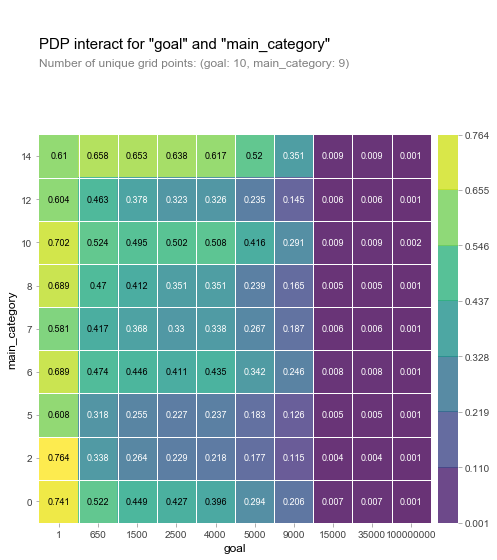

In [34]:
features = ['goal', 'main_category']

interact = pdp_interact(model5, 
                        dataset=X_val, 
                        model_features=X_val.columns, 
                        features=features)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

## Shapley Plot

### - Showing the influence of features in *individual* predictions.

In [ ]:
explainer = shap.TreeExplainer(model5)

shap_values = explainer.shap_values(X_val)

shap_values

In [78]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[-3], X_val.iloc[0,:])

## Picking most important features for model

In [ ]:
#perm_imp is set to be permutation importance of boosting model on X_val and y_val
perm_imp = permutation_importance(model5, X_val, y_val, random_state=42)
#setting data as dict of the permutation importances mean and std.
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
#setting permutation_importances to be data frame with columns in X val to be index and 'data' to be the other columns. Sorting by the mean importance from data.
permutation_importances5 = pd.DataFrame(data,index=X_val.columns).sort_values(by='imp_mean')

permutation_importances5

,imp_mean,imp_std
launch_season,-0.000147,0.000089
day,0.000230,0.000098
hour,0.000393,0.000451
month,0.000761,0.000273
time_since_last_project,0.000884,0.000144
duration_days,0.014591,0.000647
main_category,0.019855,0.000567
year,0.020505,0.000908
goal,0.056240,0.000737


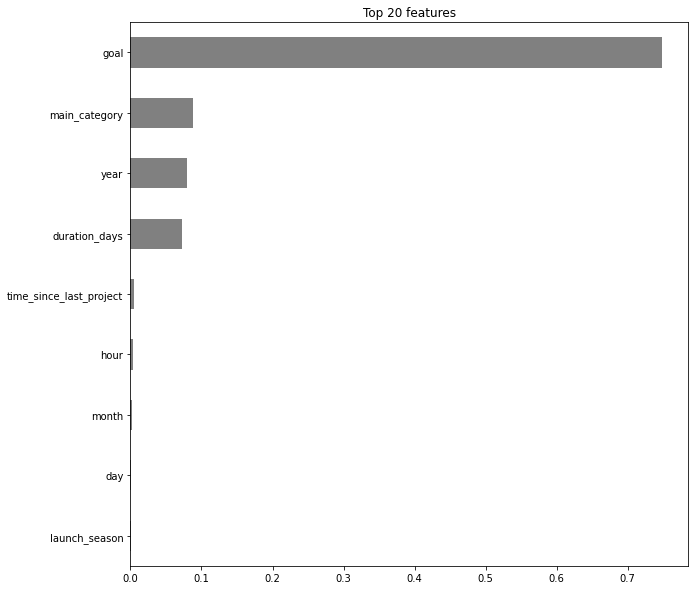

In [53]:
# Get feature importances
importances5 = pd.Series(model5.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances5.sort_values()[-n:].plot.barh(color='grey');

## Saving the model

In [217]:
pickle.dump(model5, open('Model', 'wb'))